In [65]:
import sys
import os
import glob 

import tensorflow as tf

import numpy as np
from scipy import misc 

import xml.etree.ElementTree

import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
sys.path.append('../tf_models/research/')
sys.path.append('../tf_models/research/slim/')
sys.path.append('../tf_models/research/object_detection/')

In [3]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [4]:
#there are many people and I don't want to take all memory
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)

In [5]:
# clone required utility scripts to work with models
if not os.path.isdir('../tf_models'):
    !git clone https://github.com/tensorflow/models ../tf_models

In [6]:
def load_model(m_name):
    name_to_url = {
        'ssd_mobilenet': 'http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz',
        'ssd_inception': 'http://download.tensorflow.org/models/object_detection/ssd_inception_v2_coco_11_06_2017.tar.gz',
        'rfcn': 'http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz',
        'frcnn_resnet': 'http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet101_coco_11_06_2017.tar.gz',
        'frcnn_inception' : 'http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz'
    }
    
    def find_dir():
        for p in glob.glob('bin_models/{}*'.format(m_name)):
            if os.path.isdir(p):
                return p
    
    fname = 'bin_models/{}.tar.gz'.format(m_name)
    if not os.path.exists(fname): 
        if not os.path.exists('bin_models'):
            os.makedirs('bin_models')

        download_path = name_to_url[m_name]
                
        !wget $download_path -O $fname
        !tar -xf $fname -C bin_models
        
    model_dir = find_dir() 
    
    graph = tf.Graph()    
    with graph.as_default():
        
#         with tf.gfile.GFile(os.path.join(model_dir, 'frozen_inference_graph_trained.pb'), 'rb') as in_file:
        with tf.gfile.GFile('/home/kolga/kolga/term7-DL/data/frozen_inference_graph.pb', 'rb') as in_file:
            graph_def = tf.GraphDef() 
            graph_data = in_file.read()                       
            graph_def.ParseFromString(graph_data)            
            tf.import_graph_def(graph_def, name='')        
    
    return graph

In [7]:
graph_detect = load_model('ssd_mobilenet')

In [8]:
NUM_CLASSES = 20

label_map = label_map_util.load_labelmap('../tf_models/research/object_detection/data/pascal_label_map.pbtxt')
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [13]:
class ObjectInfo:
    def __init__(self, class_name, ymin, xmin, ymax, xmax):
        self.class_name = class_name
        self.xmax = xmax
        self.xmin = xmin
        self.ymax = ymax
        self.ymin = ymin
        
    def __repr__(self):
        return '{}, xmax: {}, xmin: {}, ymax: {}, ymin: {}'.format(self.class_name, self.xmax, self.xmin,
                                                                                    self.ymax, self.ymin)

def get_object(object_node):
    name = object_node.find('name').text
    
    bndbox = object_node.find('bndbox')
    
    xmax = int(bndbox.find('xmax').text)
    xmin = int(bndbox.find('xmin').text)
    ymax = int(bndbox.find('ymax').text)
    ymin = int(bndbox.find('ymin').text)
       
    return ObjectInfo(name, ymin, xmin, ymax, xmax)

def get_annotations(fname):
    e = xml.etree.ElementTree.parse(fname).getroot()
    
    annotations = [get_object(obj_node) for obj_node in e.findall('object')]
    
    size = e.find('size')
    
    height = int(size.find('height').text)
    width = int(size.find('width').text)
    
    # normalize coordinates
    for i in range(len(annotations)):
        annotations[i].xmax *= 1./width
        annotations[i].xmin *= 1./width
        annotations[i].ymax *= 1./height
        annotations[i].ymin *= 1./height
    
    return annotations

In [14]:
VOC_DIR = '../../pascal_data/VOCdevkit/VOC2012/'
IMG_DIR = os.path.join(VOC_DIR, 'JPEGImages')
ANNOT_DIR = os.path.join(VOC_DIR, 'Annotations')

def load_images(fname):
    with open(fname) as in_file:
        files_to_load = in_file.read().splitlines()
    
    files_data = list()
    for img_fname, annot_fname in [(os.path.join(IMG_DIR, f) + '.jpg',
                                    os.path.join(ANNOT_DIR, f) + '.xml') for f in files_to_load]:
        image = misc.imread(img_fname, mode='RGB')
        annotations = get_annotations(annot_fname)
        
        files_data.append((image, annotations))

    return files_data

In [15]:
# how annotaions file looks
!cat '../../pascal_data/VOCdevkit/VOC2012/Annotations/2008_000009.xml'

<annotation>
	<folder>VOC2012</folder>
	<filename>2008_000009.jpg</filename>
	<source>
		<database>The VOC2008 Database</database>
		<annotation>PASCAL VOC2008</annotation>
		<image>flickr</image>
	</source>
	<size>
		<width>500</width>
		<height>375</height>
		<depth>3</depth>
	</size>
	<segmented>1</segmented>
	<object>
		<name>cow</name>
		<pose>Left</pose>
		<truncated>0</truncated>
		<occluded>0</occluded>
		<bndbox>
			<xmin>217</xmin>
			<ymin>161</ymin>
			<xmax>294</xmax>
			<ymax>221</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
	<object>
		<name>cow</name>
		<pose>Rear</pose>
		<truncated>1</truncated>
		<occluded>0</occluded>
		<bndbox>
			<xmin>465</xmin>
			<ymin>167</ymin>
			<xmax>500</xmax>
			<ymax>218</ymax>
		</bndbox>
		<difficult>0</difficult>
	</object>
</annotation>


In [63]:
train_data = load_images(os.path.join(VOC_DIR, 'ImageSets', 'Main', 'train.txt'))
test_data = load_images(os.path.join(VOC_DIR, 'ImageSets', 'Main', 'val.txt'))

In [64]:
train_img, train_annot = zip(*train_data)
test_img, test_annot = zip(*test_data)

In [45]:
PROB_THRESHOLD = 0.5
IOU_THRESHOLD = 0.5

In [85]:
def area(a):
    return (a.xmax - a.xmin)*(a.ymax - a.ymin)

def area_of_intersection(a, b):  # returns None if rectangles don't intersect
    dx = min(a.xmax, b.xmax) - max(a.xmin, b.xmin)
    dy = min(a.ymax, b.ymax) - max(a.ymin, b.ymin)
    if (dx>=0) and (dy>=0):
        return dx*dy
    
    return 0.

def area_of_union(a, b):
    return area(a) + area(b) - area_of_intersection(a, b)

def iou_score(a, b):
    return area_of_intersection(a, b)/area_of_union(a, b)

def mean(arr):
    if len(arr):
        return np.mean(arr)
    
    return 0

def score_detection(boxes, scores, classes, annotations):
    found_idx = scores >= PROB_THRESHOLD
    boxes_found = boxes[found_idx]
    classes_found = classes[found_idx]
       
    def find_nearest(a):
        correct = False
        max_iou = 0.
        
        for b, c in zip(boxes_found, classes_found):
            info = ObjectInfo(category_index[c]['name'], *b)
            if a.class_name == info.class_name:
                iou = iou_score(info, a)
                if iou > IOU_THRESHOLD and iou > max_iou:
                    correct = True
                    max_iou = iou
        
        return correct, max_iou
    
    total_correct = 0
    ious = list()
    
    for a in annotations:
        correct, iou = find_nearest(a)
        total_correct += int(correct)
        
        if correct:
            ious.append(iou)
    
    return 1.*total_correct/len(annotations), mean(ious)        

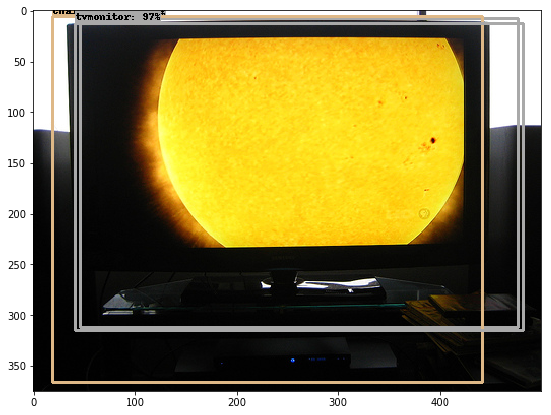

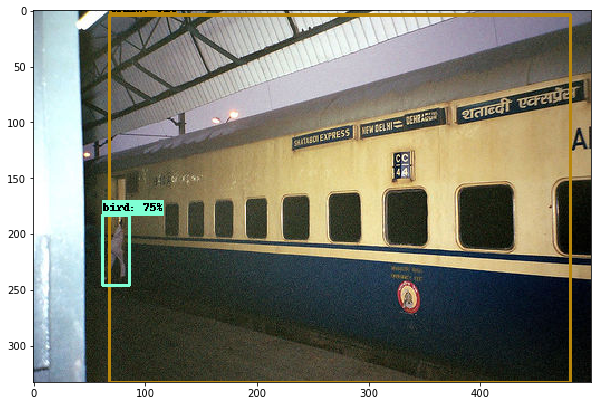

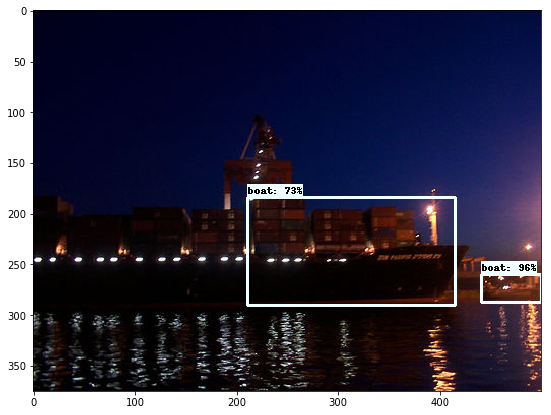

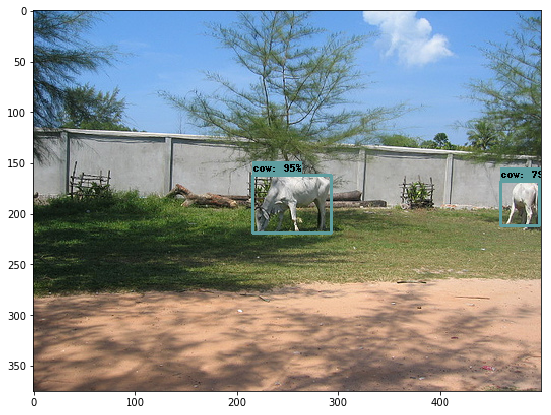

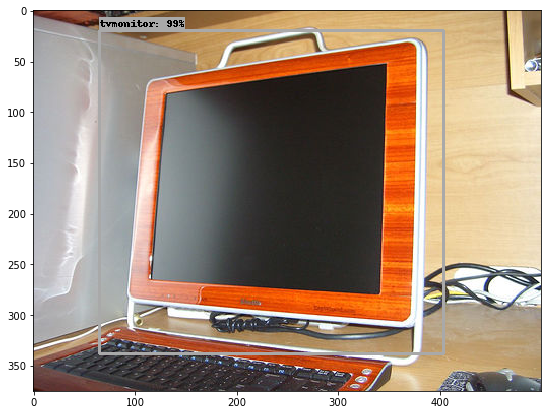

In [74]:
with tf.Session(graph=graph_detect, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    image_tensor = graph_detect.get_tensor_by_name('image_tensor:0')
    detection_boxes = graph_detect.get_tensor_by_name('detection_boxes:0')
    detection_scores = graph_detect.get_tensor_by_name('detection_scores:0')
    detection_classes = graph_detect.get_tensor_by_name('detection_classes:0')
    num_detections = graph_detect.get_tensor_by_name('num_detections:0')

    for image, annotations in tqdm.tqdm_notebook(test_data[:5]):
        image_exp = np.expand_dims(image, axis=0)
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_exp})
        
        vis_util.visualize_boxes_and_labels_on_image_array(
              image,
              np.squeeze(boxes),
              np.squeeze(classes).astype(np.int32),
                 np.squeeze(scores),
                 category_index,
                 use_normalized_coordinates=True,
                 line_thickness=3)
        plt.figure(figsize=(10, 7))
        plt.imshow(image)
        

In [101]:
acc_scores = list()
iou_scores = list()

with tf.Session(graph=graph_detect, config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    image_tensor = graph_detect.get_tensor_by_name('image_tensor:0')
    detection_boxes = graph_detect.get_tensor_by_name('detection_boxes:0')
    detection_scores = graph_detect.get_tensor_by_name('detection_scores:0')
    detection_classes = graph_detect.get_tensor_by_name('detection_classes:0')
    num_detections = graph_detect.get_tensor_by_name('num_detections:0')

    for idx, (image, annotations) in enumerate(tqdm.tqdm_notebook(test_data)):
        image_exp = np.expand_dims(image, axis=0)
        (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_exp})
    
        acc, iou = score_detection(boxes[0], scores[0], classes[0], annotations)

        acc_scores.append(acc)
        
        if iou > 0.:
            iou_scores.append(iou)
            
        if idx % 10 == 0:
            msg = u'Accuracy: {:.3f}±{:.3f}; IoU: {:.3f}±{:.3f}'.format(np.mean(acc_scores), np.std(acc_scores),
                                                                        np.mean(iou_scores), np.std(iou_scores))
            print(msg, end='\r')
            

Accuracy: 0.816±0.286; IoU: 0.827±0.083
